# Thử nghiệm và Cải tiến cho Co-Training

**Mục tiêu:**
Notebook này thực hiện quá trình sweep (thử nghiệm) các tham số và chiến lược tách view khác nhau cho thuật toán Co-Training nhằm tìm ra cấu hình tối ưu và cải thiện hiệu năng so với kết quả ban đầu.

**Các bước thực hiện:**
1.  Định nghĩa các bộ tham số và chiến lược tách view để thử nghiệm:
    *   `TAU` (Ngưỡng tự tin): `[0.9, 0.8]`
    *   `MAX_NEW_PER_ITER` (Số mẫu mới tối đa mỗi vòng): `[250, 500]`
    *   **View Splitting Strategies**:
        *   `default`: Tách tự động (sensor/lag vs. context/time).
        *   `manual`: Tách thủ công các feature thời tiết sang View 2.
2.  Sử dụng `papermill` để chạy notebook `05_semi_co_training.ipynb` với 8 cấu hình khác nhau.
3.  Tự động lưu kết quả vào thư mục `data/processed/` với tiền tố `11_ID_*`.
4.  Tổng hợp và trực quan hóa kết quả để so sánh hiệu năng và chọn ra mô hình tốt nhất.

In [26]:
from pathlib import Path
import papermill as pm
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# -------- Cấu hình thử nghiệm --------
PROJECT_ROOT = Path(".").resolve().parent
print(f"Project Root: {PROJECT_ROOT}")

KERNEL = "KhaiPhaDuLieu"

# --- Tham số để sweep ---
TAU_LIST = [0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]
MAX_NEW_PER_ITER_LIST = [250, 500] # Thêm điểm để vẽ biểu đồ đường

# --- Chiến lược tách view ---
# Đọc danh sách features từ file đã tạo ở notebook 03
feature_list_path = PROJECT_ROOT / "data" / "processed" / "03_feature_list.csv"
df_features = pd.read_csv(feature_list_path)
all_features = df_features["feature"].tolist()

# 1. Manual split: View 2 chứa các đặc trưng thời tiết, View 1 chứa phần còn lại
manual_view2_cols = [col for col in all_features if any(sub in col for sub in ["wd", "temp", "pres", "humi"])]
manual_view1_cols = [col for col in all_features if col not in manual_view2_cols]

# 2. PCA-based split: Tách dựa trên principal components
print("Tính toán PCA-based split...")
semi_dataset_path = PROJECT_ROOT / "data" / "processed" / "02_dataset_for_semi.parquet"
df_semi = pd.read_parquet(semi_dataset_path)

# Chỉ sử dụng labeled data để tính PCA
df_labeled = df_semi[df_semi["is_labeled"] == True].copy()

# Lọc chỉ các features numeric (loại bỏ categorical như 'wd', 'station')
numeric_features = [col for col in all_features if col not in ['wd', 'station']]
X_labeled = df_labeled[numeric_features].fillna(0)  # Fill NaN nếu có

# Chuẩn hóa và tính PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_labeled)

# Tính PCA với số components bằng số features
n_components = min(20, len(numeric_features))  # Giới hạn số PC để tăng tốc
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

# Lấy absolute loadings và phân chia features
# View 1: Features có loading cao ở các PC chẵn (PC0, PC2, PC4,...)
# View 2: Features có loading cao ở các PC lẻ (PC1, PC3, PC5,...)
loadings = np.abs(pca.components_)  # Shape: (n_components, n_features)

even_pcs = loadings[0::2, :]  # PC0, PC2, PC4,...
odd_pcs = loadings[1::2, :]   # PC1, PC3, PC5,...

# Tính tổng loading cho mỗi feature
even_loadings = even_pcs.sum(axis=0)
odd_loadings = odd_pcs.sum(axis=0)

# Phân chia features dựa trên loading cao hơn
pca_view1_cols = [numeric_features[i] for i in range(len(numeric_features)) if even_loadings[i] >= odd_loadings[i]]
pca_view2_cols = [numeric_features[i] for i in range(len(numeric_features)) if even_loadings[i] < odd_loadings[i]]

# Thêm categorical features vào view1 (nếu có)
categorical_features = [col for col in all_features if col in ['wd', 'station']]
if categorical_features:
    pca_view1_cols.extend(categorical_features)

print(f"PCA split: View1={len(pca_view1_cols)} features, View2={len(pca_view2_cols)} features")

VIEW_STRATEGIES = {
    "default": {
        "VIEW1_COLS": None,  # Để notebook 05 tự tách
        "VIEW2_COLS": None,
    },
    "manual_weather_split": {
        "VIEW1_COLS": manual_view1_cols,
        "VIEW2_COLS": manual_view2_cols,
    },
    "pca_based_split": {
        "VIEW1_COLS": pca_view1_cols,
        "VIEW2_COLS": pca_view2_cols,
    }
}

Project Root: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard
Tính toán PCA-based split...
PCA split: View1=33 features, View2=18 features


In [ ]:
# -------- Chạy thử nghiệm với Papermill --------
# Tạo thư mục runs nếu chưa có
runs_dir = Path("runs")
runs_dir.mkdir(exist_ok=True)

experiment_id = 1
config_list = []

# Tạo danh sách tất cả các cấu hình
for view_name, view_cols in VIEW_STRATEGIES.items():
    for tau in TAU_LIST:
        for max_new in MAX_NEW_PER_ITER_LIST:
            config_list.append({
                "view_name": view_name,
                "tau": tau,
                "max_new_per_iter": max_new,
                "view1_cols": view_cols["VIEW1_COLS"],
                "view2_cols": view_cols["VIEW2_COLS"],
            })

# Chạy lặp qua các cấu hình
total_experiments = len(config_list)
for config in config_list:
    print(f"--- Thử nghiệm {experiment_id}/{total_experiments}: "
          f"View='{config['view_name']}', TAU={config['tau']}, MAX_NEW={config['max_new_per_iter']} ---")

    metrics_path = f"data/processed/11_{experiment_id:02d}_metrics_co_training.json"
    output_notebook_path = f"runs/11_{experiment_id:02d}_co_training_run.ipynb"

    try:
        pm.execute_notebook(
            input_path="05_semi_co_training.ipynb",
            output_path=output_notebook_path,
            parameters=dict(
                SEMI_DATASET_PATH="data/processed/02_dataset_for_semi.parquet",
                CUTOFF="2017-01-01",
                TAU=config["tau"],
                MAX_ITER=5, # Giữ nguyên MAX_ITER
                MAX_NEW_PER_ITER=config["max_new_per_iter"],
                MIN_NEW_PER_ITER=200,
                VAL_FRAC=0.1,
                RANDOM_STATE=42,
                METRICS_PATH=metrics_path,
                # Không cần lưu sample predictions/alerts cho sweep
                PRED_SAMPLE_PATH=None, 
                ALERTS_SAMPLE_PATH=None,
                ALERT_FROM_CLASS="Unhealthy",
                VIEW1_COLS=config["view1_cols"],
                VIEW2_COLS=config["view2_cols"],
            ),
            kernel_name=KERNEL,
            cwd=str(PROJECT_ROOT)
        )
        print(f"✅ Hoàn thành và lưu kết quả tại: {metrics_path}")
    except Exception as e:
        print(f"❌ Lỗi khi chạy thử nghiệm {experiment_id}: {e}")
    
    experiment_id += 1

print("\n🎉 Tất cả thử nghiệm Co-Training đã hoàn tất!")

# Tổng hợp và Phân tích kết quả

Chúng ta sẽ đọc tất cả các file metrics đã được tạo ra, tổng hợp chúng vào một DataFrame và hiển thị kết quả để so sánh.

In [48]:
import json
import pandas as pd
from pathlib import Path
from IPython.display import display

# -------- Cấu hình --------
PROJECT_ROOT = Path(".").resolve().parent
DATA_DIR = PROJECT_ROOT / "data" / "processed"
TOTAL_EXPERIMENTS = len(VIEW_STRATEGIES) * len(TAU_LIST) * len(MAX_NEW_PER_ITER_LIST)  # 3 strategies × 2 TAU × 2 MAX_NEW

# -------- Đọc và tổng hợp kết quả --------
results = []
for i in range(1, TOTAL_EXPERIMENTS + 1):
    metrics_path = DATA_DIR / f"11_{i:02d}_metrics_co_training.json"
    
    if metrics_path.exists():
        with open(metrics_path, "r", encoding="utf-8") as f:
            data = json.load(f)
            
            # Trích xuất thông tin
            config = data.get("ct_cfg", {})
            test_metrics = data.get("test_metrics", {})
            
            # Xác định view strategy dựa trên số lượng cột
            view_strategy = "default"
            if config.get("view1_cols_count") is not None:
                 if config.get("view1_cols_count") == len(manual_view1_cols):
                     view_strategy = "manual_weather_split"
                 elif config.get("view1_cols_count") == len(pca_view1_cols):
                     view_strategy = "pca_based_split"

            results.append({
                "experiment_id": i,
                "view_strategy": view_strategy,
                "tau": config.get("tau"),
                "max_new_per_iter": config.get("max_new_per_iter"),
                "f1_macro": test_metrics.get("f1_macro"),
                "accuracy": test_metrics.get("accuracy"),
            })
    else:
        print(f"Cảnh báo: Không tìm thấy file {metrics_path}")

# Tạo DataFrame
if results:
    df_results_co = pd.DataFrame(results)
    df_results_co["label"] = (
        df_results_co["view_strategy"]
        + "\nTAU=" + df_results_co["tau"].astype(str)
        + ", MAX_NEW=" + df_results_co["max_new_per_iter"].astype(str)
    )
    
    print("Bảng tổng hợp kết quả thử nghiệm Co-Training:")
    display(df_results_co.sort_values("f1_macro", ascending=False))

else:    print("Không có kết quả nào để hiển thị.")

Cảnh báo: Không tìm thấy file E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\11_15_metrics_co_training.json
Cảnh báo: Không tìm thấy file E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\11_16_metrics_co_training.json
Cảnh báo: Không tìm thấy file E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\11_17_metrics_co_training.json
Cảnh báo: Không tìm thấy file E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\11_18_metrics_co_training.json
Cảnh báo: Không tìm thấy file E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\11_19_metrics_co_training.json
Cảnh báo: Không tìm thấy file E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\11_20_metrics_co_training.json
Cảnh báo: Không tìm thấy file E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\11_21_metrics_co_training.json
Cảnh báo: Không tìm thấy file E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\11_22_metrics_co_training.json
Cảnh báo: Không 

,experiment_id,view_strategy,tau,max_new_per_iter,f1_macro,accuracy,label
5,6,default,0.80,500,0.420508,0.552636,"default\nTAU=0.8, MAX_NEW=500"
11,12,default,0.65,500,0.417534,0.552096,"default\nTAU=0.65, MAX_NEW=500"
1,2,default,0.90,500,0.415860,0.540040,"default\nTAU=0.9, MAX_NEW=500"
7,8,default,0.75,500,0.415295,0.542799,"default\nTAU=0.75, MAX_NEW=500"
10,11,default,0.65,250,0.412998,0.545618,"default\nTAU=0.65, MAX_NEW=250"
4,5,default,0.80,250,0.412929,0.543159,"default\nTAU=0.8, MAX_NEW=250"
9,10,default,0.70,500,0.411438,0.548617,"default\nTAU=0.7, MAX_NEW=500"
12,13,default,0.60,250,0.411023,0.548737,"default\nTAU=0.6, MAX_NEW=250"
0,1,default,0.90,250,0.410118,0.540939,"default\nTAU=0.9, MAX_NEW=250"
2,3,default,0.85,250,0.408808,0.553296,"default\nTAU=0.85, MAX_NEW=250"


# Trực quan hóa kết quả

Phần này sẽ trực quan hóa kết quả thử nghiệm Co-Training qua nhiều loại biểu đồ khác nhau để phân tích toàn diện hiệu năng của các cấu hình.

### Quy tắc màu sắc cho biểu đồ

**Palette chính (3 tông màu để phân biệt View Strategies):**
- 🔵 **Default**: `#1F62FF` (Xanh nước biển đậm)
- 🟠 **Manual Weather Split**: `#FF9A1F` (Cam đậm)
- 🟢 **PCA Based Split**: `#1FFF2A` (Xanh lá đậm)

**Gradient cho Heatmap & Ranked Chart (3 tông màu):**
- 🔴 Đỏ `#FF351F` (Hiệu năng thấp)
- 🟡 Vàng `#FFDA1F` (Hiệu năng trung bình)
- 🟢 Xanh lá `#1FFF2A` (Hiệu năng cao)

**Phương pháp phân biệt thêm:**
- Line style: `─` (solid) cho MAX_NEW=250, `- -` (dashed) cho MAX_NEW=500
- Marker: `○` (circle) cho MAX_NEW=250, `□` (square) cho MAX_NEW=500
- Độ đậm/kích thước khác nhau để tăng khả năng phân biệt

In [49]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# -------- Cấu hình biểu đồ --------
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11

IMAGES_DIR = PROJECT_ROOT / "images"
IMAGES_DIR.mkdir(exist_ok=True)

FONT_CONFIG = {'fontname': 'Arial', 'fontsize': 11}

# Palette chính (phân biệt view strategies khi cần)
PALETTE = {
    "default": "#1F62FF",              # Xanh dương đậm
    "manual_weather_split": "#FF9A1F", # Cam
    "pca_based_split": "#1FFF2A"       # Xanh lá
}

# Gradient XANH DƯƠNG cho heatmap và ranked chart
CMAP_BLUE_GRADIENT = LinearSegmentedColormap.from_list(
    "blue_gradient", 
    ["#1FD2FF", "#1F62FF"], # Từ xanh nhạt đến xanh đậm
    N=256
)

print("✅ Cấu hình biểu đồ hoàn tất!")

✅ Cấu hình biểu đồ hoàn tất!


## 1. Heatmap tổng quan hiệu năng

Heatmap giúp trực quan hóa hiệu năng (F1-macro) của tất cả các tổ hợp tham số. Mỗi view strategy sẽ có một heatmap riêng.

✅ Heatmap đã được lưu tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\11_heatmap_performance.png


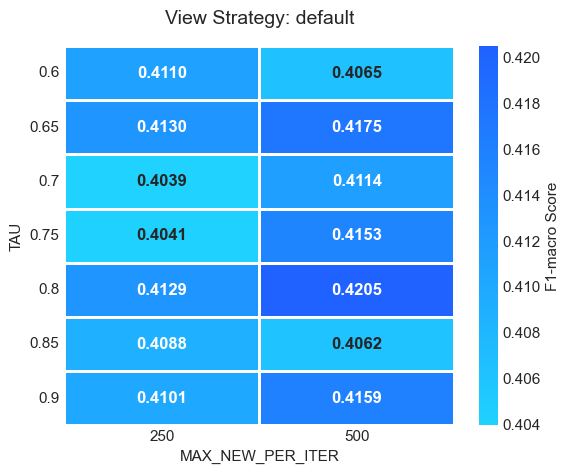

In [50]:
# -------- 1. Heatmap: F1-macro theo TAU và MAX_NEW_PER_ITER --------
if 'df_results_co' in locals() and not df_results_co.empty:
    
    strategies = df_results_co['view_strategy'].unique()
    n_strategies = len(strategies)
    
    fig, axes = plt.subplots(1, n_strategies, figsize=(6*n_strategies, 5), squeeze=False)
    
    for idx, strategy in enumerate(strategies):
        ax = axes[0, idx]
        strategy_data = df_results_co[df_results_co['view_strategy'] == strategy]
        
        pivot_data = strategy_data.pivot_table(
            index='tau', 
            columns='max_new_per_iter', 
            values='f1_macro'
        )
        
        # Vẽ heatmap với gradient XANH DƯƠNG
        # annot=True sẽ tự động xử lý màu chữ để đảm bảo dễ đọc.
        sns.heatmap(
            pivot_data,
            annot=True,
            fmt='.4f',
            cmap=CMAP_BLUE_GRADIENT, # Sử dụng gradient xanh
            ax=ax,
            cbar_kws={'label': 'F1-macro Score'},
            linewidths=2,
            linecolor='white',
            vmin=df_results_co['f1_macro'].min(),
            vmax=df_results_co['f1_macro'].max(),
            annot_kws={'fontsize': 12, 'fontweight': 'bold'}
        )
        
        # Định dạng
        ax.set_title(f'View Strategy: {strategy}', fontsize=14, pad=16)
        ax.set_xlabel('MAX_NEW_PER_ITER', fontsize=11)
        ax.set_ylabel('TAU', fontsize=11)
        ax.tick_params(axis='x', rotation=0, labelsize=11)
        ax.tick_params(axis='y', rotation=0, labelsize=11)
    
    plt.tight_layout(pad=1.5)
    
    save_path = IMAGES_DIR / "11_heatmap_performance.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Heatmap đã được lưu tại: {save_path}")
    
    plt.show()
else:
    print("⚠️ Không có dữ liệu để vẽ biểu đồ.")

## 2. Line plot xu hướng theo TAU

### Ý nghĩa biểu đồ
Biểu đồ đường giúp quan sát sự thay đổi của F1-macro khi TAU thay đổi.

- **Màu sắc**: Phân biệt `MAX_NEW`.
    - 🔵 Xanh đậm (`#1F62FF`): `MAX_NEW=250`
    - 🌐 Xanh nhạt (`#1FD2FF`): `MAX_NEW=500`
- **Line Style**: Mỗi `view_strategy` sẽ có một kiểu đường khác nhau (nếu có nhiều strategy).

*Lưu ý: Nếu bạn chỉ thấy 2 đường, có thể các thử nghiệm cho `view_strategy` khác chưa được chạy hoặc chưa có kết quả.*

✅ Faceted line plot đã được lưu tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\11_lineplot_tau_trend_faceted.png


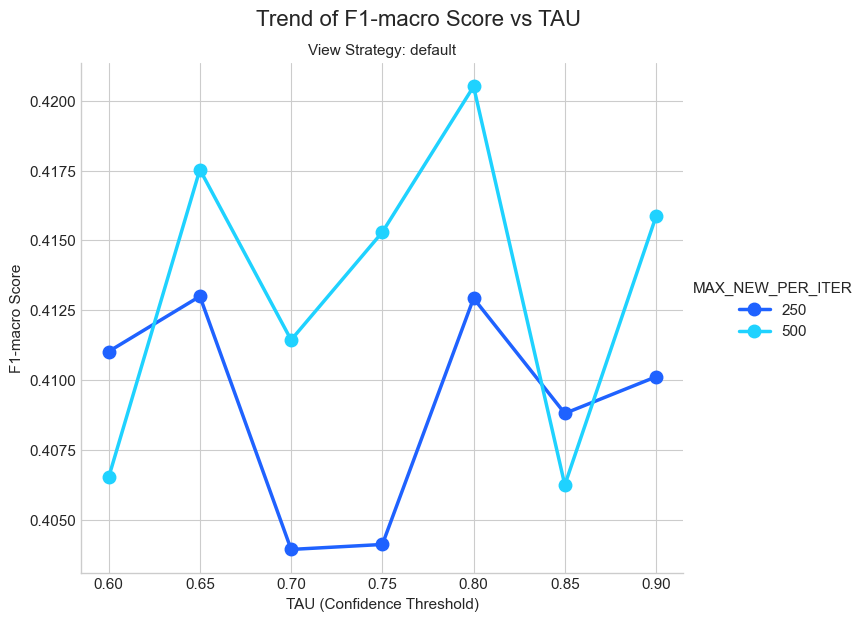

In [51]:
# -------- 2. Line Plot: Xu hướng F1-macro theo TAU (Faceted) --------
if 'df_results_co' in locals() and not df_results_co.empty:
    
    # Sử dụng FacetGrid để tách mỗi strategy ra một biểu đồ con
    g = sns.FacetGrid(
        df_results_co, 
        col="view_strategy", 
        hue="max_new_per_iter",
        hue_order=[250, 500],
        palette=["#1F62FF", "#1FD2FF"], # Xanh đậm, Xanh nhạt
        height=6,
        aspect=1.2
    )
    
    # Vẽ biểu đồ đường trên mỗi facet
    g.map(plt.plot, "tau", "f1_macro", marker='o', markersize=9, linewidth=2.5)
    
    # Tùy chỉnh biểu đồ
    g.set_axis_labels("TAU (Confidence Threshold)", "F1-macro Score")
    g.set_titles("View Strategy: {col_name}")
    g.fig.suptitle('Trend of F1-macro Score vs TAU', fontsize=16, y=1.03)
    g.add_legend(title='MAX_NEW_PER_ITER')
    
    # Lưu biểu đồ
    save_path = IMAGES_DIR / "11_lineplot_tau_trend_faceted.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Faceted line plot đã được lưu tại: {save_path}")
    
    plt.show()
else:
    print("⚠️ Không có dữ liệu để vẽ biểu đồ.")

## 3. Grouped bar chart so sánh tổng thể

Biểu đồ cột với màu gradient thể hiện hiệu năng, sắp xếp từ cao đến thấp.

✅ Grouped bar chart đã được lưu tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\11_grouped_barchart_ranked.png


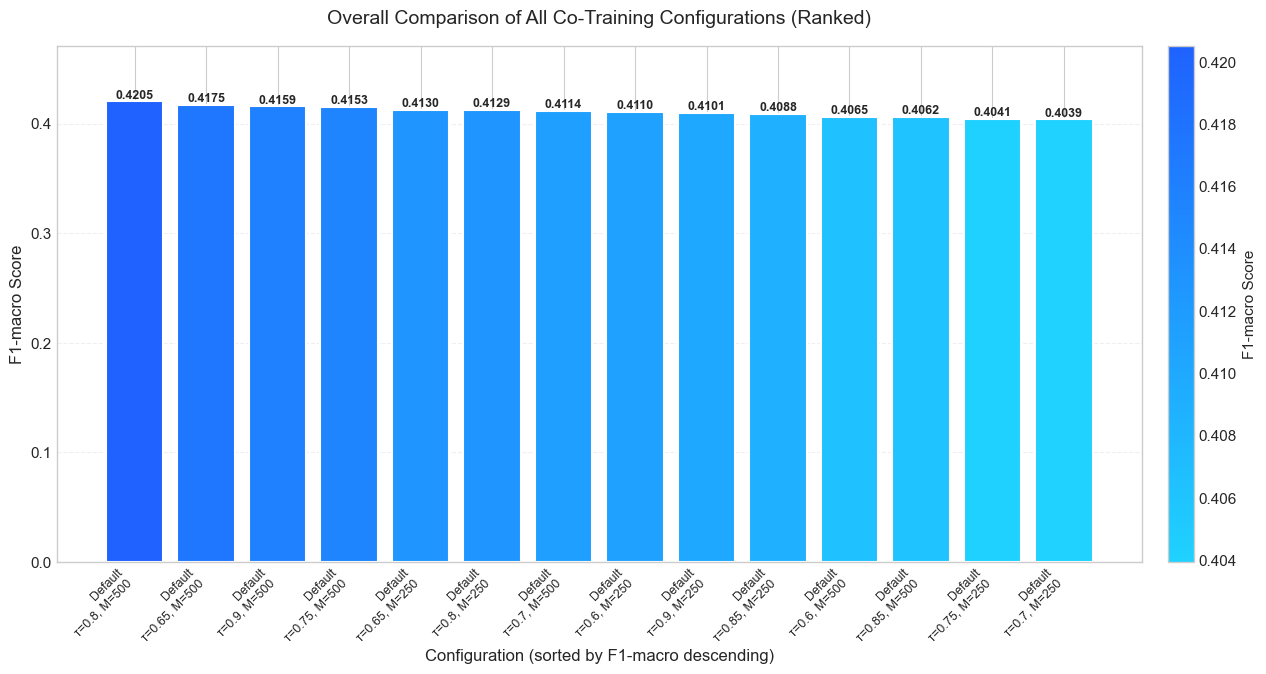

In [52]:
# -------- 3. Grouped Bar Chart: So sánh tổng thể với màu gradient --------
if 'df_results_co' in locals() and not df_results_co.empty:
    
    # Sắp xếp theo F1-macro giảm dần
    df_sorted = df_results_co.sort_values('f1_macro', ascending=False).reset_index(drop=True)
    
    # Tạo gradient màu XANH DƯƠNG
    norm = Normalize(vmin=df_sorted['f1_macro'].min(), vmax=df_sorted['f1_macro'].max())
    colors = [CMAP_BLUE_GRADIENT(norm(val)) for val in df_sorted['f1_macro']]
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Tạo nhãn ngắn gọn
    df_sorted['short_label'] = (
        df_sorted['view_strategy'].str.replace('_', ' ').str.title() + 
        '\nτ=' + df_sorted['tau'].astype(str) + 
        ', M=' + df_sorted['max_new_per_iter'].astype(str)
    )
    
    # Vẽ bar chart
    bars = ax.bar(
        range(len(df_sorted)),
        df_sorted['f1_macro'],
        color=colors,
        edgecolor='white',
        linewidth=1.5
    )
    
    # Thêm giá trị trên mỗi cột
    for bar, value in zip(bars, df_sorted['f1_macro']):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height,
            f'{value:.4f}',
            ha='center',
            va='bottom',
            fontsize=9,
            fontweight='bold'
        )
    
    # Định dạng
    ax.set_xlabel('Configuration (sorted by F1-macro descending)', fontsize=12)
    ax.set_ylabel('F1-macro Score', fontsize=12)
    ax.set_title('Overall Comparison of All Co-Training Configurations (Ranked)', fontsize=14, pad=16)
    ax.set_xticks(range(len(df_sorted)))
    ax.set_xticklabels(df_sorted['short_label'], rotation=45, ha='right', fontsize=9)
    ax.set_ylim(0, df_sorted['f1_macro'].max() * 1.12)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Thêm colorbar
    sm = ScalarMappable(cmap=CMAP_BLUE_GRADIENT, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label('F1-macro Score', fontsize=11)
    
    plt.tight_layout(pad=1.5)
    
    # Lưu biểu đồ
    save_path = IMAGES_DIR / "11_grouped_barchart_ranked.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Grouped bar chart đã được lưu tại: {save_path}")
    
    plt.show()
else:
    print("⚠️ Không có dữ liệu để vẽ biểu đồ.")

## 4. Box plot phân phối hiệu năng

### Ý nghĩa biểu đồ
Box plot so sánh sự phân tán về hiệu năng (F1-macro) của các `view_strategy` khác nhau.
- **Hộp (box)**: Chứa 50% dữ liệu ở giữa (từ Q1 đến Q3).
- **Đường kẻ giữa hộp**: Median (giá trị trung vị).
- **Hình thoi (diamond)**: Mean (giá trị trung bình).
- **Các điểm tròn**: Từng kết quả thử nghiệm riêng lẻ.

Biểu đồ này giúp đánh giá:
1.  **Hiệu năng trung bình**: Chiến lược nào có mean/median cao hơn.
2.  **Độ ổn định**: Hộp càng ngắn, các kết quả càng ít dao động, chiến lược đó càng ổn định.

*Lưu ý: Nếu bạn chỉ thấy một box "Default", điều này có nghĩa là các thử nghiệm cho `manual_weather_split` và `pca_based_split` chưa được chạy hoặc chưa có kết quả để tổng hợp.*

✅ Box plot phân phối đã được lưu tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\11_boxplot_distribution.png


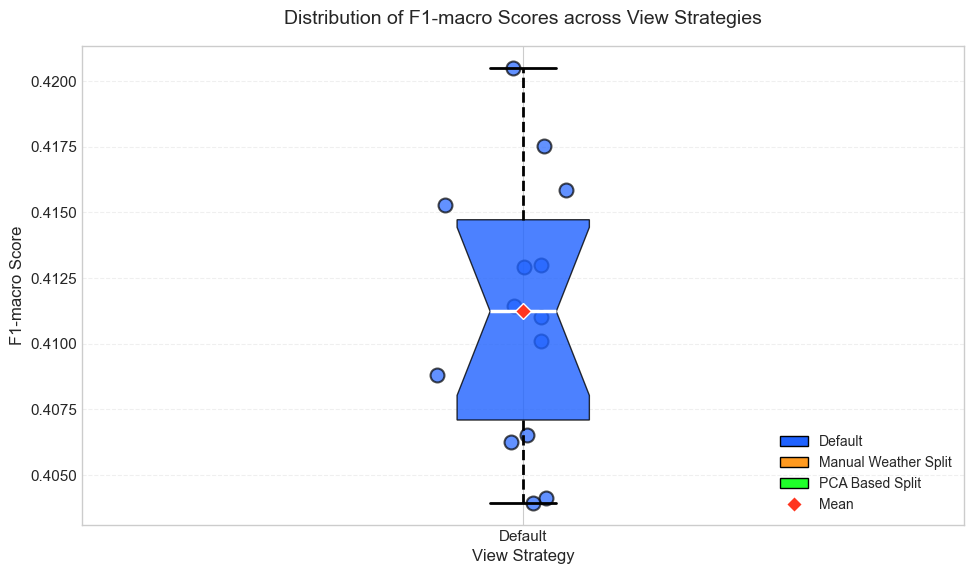

In [53]:
# -------- 4. Box Plot: Phân phối hiệu năng theo View Strategy --------
if 'df_results_co' in locals() and not df_results_co.empty:
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    strategies = df_results_co['view_strategy'].unique()
    data_by_strategy = [df_results_co[df_results_co['view_strategy'] == s]['f1_macro'].values for s in strategies]
    labels = [s.replace('_', ' ').title() for s in strategies]
    
    # Tạo box plot
    box_parts = ax.boxplot(
        data_by_strategy,
        labels=labels,
        patch_artist=True,
        notch=True,
        showmeans=True,
        meanprops=dict(marker='D', markerfacecolor='#FF351F', markeredgecolor='white', markersize=8)
    )
    
    # Tô màu cho từng box (sử dụng 3 tông màu chính)
    for patch, strategy in zip(box_parts['boxes'], strategies):
        patch.set_facecolor(PALETTE.get(strategy, '#1F62FF'))
        patch.set_alpha(0.8)  # Tăng độ đậm để rõ hơn
        patch.set_edgecolor('black')
        patch.set_linewidth=2.0  # Viền đậm hơn
    
    # Định dạng whiskers, caps, medians (màu đen để tương phản)
    for whisker in box_parts['whiskers']:
        whisker.set(linewidth=2.0, linestyle='--', color='black')
    for cap in box_parts['caps']:
        cap.set(linewidth=2.0, color='black')
    for median in box_parts['medians']:
        median.set(linewidth=2.5, color='white')  # Median màu trắng nổi bật
    
    # Thêm scatter plot cho các điểm dữ liệu (cùng màu với box)
    for i, strategy in enumerate(strategies, 1):
        strategy_data = df_results_co[df_results_co['view_strategy'] == strategy]['f1_macro']
        y_data = strategy_data.values
        x_data = np.random.normal(i, 0.04, size=len(y_data))
        ax.scatter(x_data, y_data, alpha=0.7, s=100, edgecolors='black', 
                  linewidth=1.5, color=PALETTE.get(strategy, '#1F62FF'))
    
    # Định dạng
    ax.set_xlabel('View Strategy', fontsize=12)
    ax.set_ylabel('F1-macro Score', fontsize=12)
    ax.set_title('Distribution of F1-macro Scores across View Strategies', fontsize=14, pad=16)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Thêm legend
    legend_elements = [
        mpatches.Patch(facecolor=PALETTE['default'], edgecolor='black', label='Default'),
        mpatches.Patch(facecolor=PALETTE['manual_weather_split'], edgecolor='black', label='Manual Weather Split'),
        mpatches.Patch(facecolor=PALETTE['pca_based_split'], edgecolor='black', label='PCA Based Split'),
        plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='#FF351F', 
                   markersize=8, label='Mean', markeredgecolor='white')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    plt.tight_layout(pad=1.5)
    
    # Lưu biểu đồ
    save_path = IMAGES_DIR / "11_boxplot_distribution.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Box plot phân phối đã được lưu tại: {save_path}")
    
    plt.show()
else:
    print("⚠️ Không có dữ liệu để vẽ biểu đồ.")

## 5. Scatter plot tương quan tham số

### Ý nghĩa biểu đồ
Biểu đồ scatter plot thể hiện mối quan hệ giữa các tham số:
- **Trục X**: Ngưỡng tự tin `TAU`.
- **Trục Y**: Điểm `F1-macro`.
- **Màu sắc**: Phân biệt `MAX_NEW` (250 vs 500).
- **Đường đứt nét**: Đường xu hướng chung, cho thấy mối tương quan tổng thể giữa `TAU` và `F1-macro`.

Biểu đồ giúp trả lời câu hỏi: "Liệu việc tăng/giảm `TAU` có ảnh hưởng đến hiệu năng không, và ảnh hưởng đó khác nhau như thế nào giữa `MAX_NEW=250` và `MAX_NEW=500`?"

✅ Faceted scatter plot đã được lưu tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\11_scatterplot_correlation_faceted.png


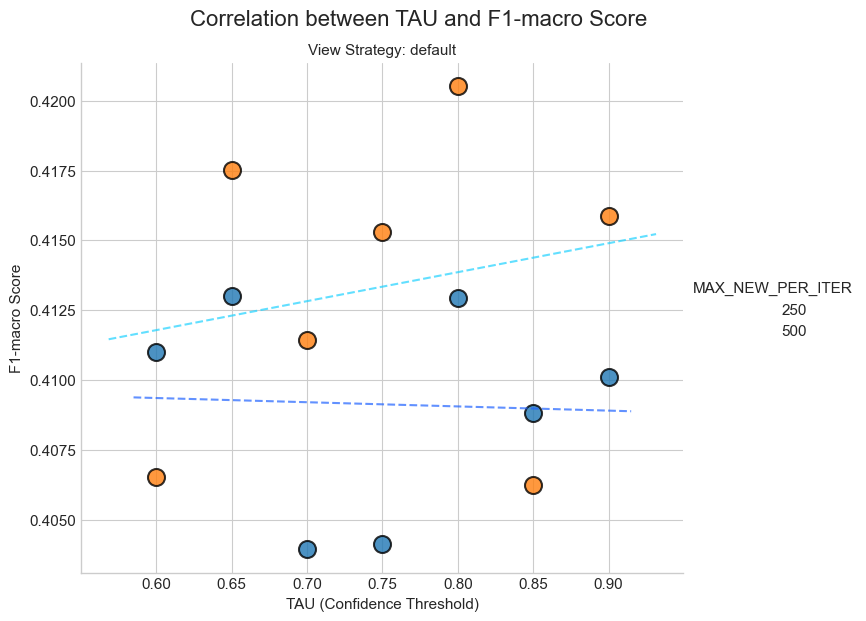

In [54]:
# -------- 5. Scatter Plot: Tương quan giữa TAU và F1-macro (Faceted) --------
if 'df_results_co' in locals() and not df_results_co.empty:

    # Hàm để vẽ scatter plot và trendline
    def scatter_trend(x, y, color, label, **kwargs):
        ax = plt.gca()
        ax.scatter(x, y, **kwargs)
        # Vẽ trendline cho từng nhóm nhỏ
        if len(x) > 1:
            slope, intercept, r, p, se = linregress(x, y)
            x_vals = np.array(ax.get_xlim())
            y_vals = intercept + slope * x_vals
            ax.plot(x_vals, y_vals, color=color, linestyle='--', alpha=0.7)

    # Sử dụng FacetGrid
    g = sns.FacetGrid(
        df_results_co, 
        col="view_strategy", 
        hue="max_new_per_iter",
        hue_order=[250, 500],
        palette=["#1F62FF", "#1FD2FF"],
        height=6,
        aspect=1.2
    )
    
    # Vẽ biểu đồ scatter và trendline trên mỗi facet
    g.map(scatter_trend, "tau", "f1_macro", s=150, alpha=0.8, edgecolor='black', linewidth=1.5)

    # Tùy chỉnh
    g.set_axis_labels("TAU (Confidence Threshold)", "F1-macro Score")
    g.set_titles("View Strategy: {col_name}")
    g.fig.suptitle('Correlation between TAU and F1-macro Score', fontsize=16, y=1.03)
    g.add_legend(title='MAX_NEW_PER_ITER')
    
    # Lưu biểu đồ
    save_path = IMAGES_DIR / "11_scatterplot_correlation_faceted.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Faceted scatter plot đã được lưu tại: {save_path}")
    
    plt.show()
else:
    print("⚠️ Không có dữ liệu để vẽ biểu đồ.")

## 6. Bảng tổng hợp kết quả (Tối giản)

Bảng tổng hợp kết quả, sắp xếp theo F1-macro giảm dần. Phiên bản này đã loại bỏ màu sắc ở các dòng để tăng tính trực quan, dễ đọc.

In [55]:
# -------- 6. Summary Table (Tối giản) --------
if 'df_results_co' in locals() and not df_results_co.empty:
    
    from IPython.display import display
    
    # Sắp xếp và tính toán
    df_summary = df_results_co.sort_values('f1_macro', ascending=False).reset_index(drop=True)
    df_summary.insert(0, 'rank', range(1, len(df_summary) + 1))
    
    baseline_mask = (df_summary['view_strategy'] == 'default') & (df_summary['tau'] == 0.9) & (df_summary['max_new_per_iter'] == 250)
    baseline_f1 = df_summary.loc[baseline_mask, 'f1_macro'].iloc[0] if baseline_mask.any() else df_summary['f1_macro'].mean()
    df_summary['improvement_vs_baseline'] = ((df_summary['f1_macro'] - baseline_f1) / baseline_f1 * 100).round(2)
    
    # Chọn cột và đổi tên
    display_cols = ['rank', 'view_strategy', 'tau', 'max_new_per_iter', 'f1_macro', 'accuracy', 'improvement_vs_baseline']
    df_display = df_summary[display_cols].copy()
    df_display.columns = ['Rank', 'View Strategy', 'TAU', 'MAX_NEW', 'F1-macro', 'Accuracy', 'Improvement (%)']
    
    # Styling tối giản: chỉ header
    styled_table = df_display.style.format({
        'F1-macro': '{:.4f}',
        'Accuracy': '{:.4f}',
        'Improvement (%)': '{:+.2f}'
    }).set_table_styles([
        {'selector': 'th', 'props': [
            ('background-color', '#1F62FF'),
            ('color', 'white'),
            ('font-weight', 'bold'),
            ('text-align', 'center'),
            ('font-family', 'Arial'),
            ('font-size', '12pt'),
            ('padding', '0.5em')
        ]},
        {'selector': 'td', 'props': [
            ('text-align', 'center'),
            ('font-family', 'Arial'),
            ('padding', '0.5em')
        ]}
    ])
    
    print("=" * 60)
    print("SUMMARY TABLE - CO-TRAINING CONFIGURATIONS")
    print("=" * 60)
    display(styled_table)
    
    globals()['df_display'] = df_display
else:
    print("⚠️ Không có dữ liệu để hiển thị.")

SUMMARY TABLE - CO-TRAINING CONFIGURATIONS


,Rank,View Strategy,TAU,MAX_NEW,F1-macro,Accuracy,Improvement (%)
0,1,default,0.800000,500,0.4205,0.5526,+2.53
1,2,default,0.650000,500,0.4175,0.5521,+1.81
2,3,default,0.900000,500,0.4159,0.5400,+1.40
3,4,default,0.750000,500,0.4153,0.5428,+1.26
4,5,default,0.650000,250,0.4130,0.5456,+0.70
5,6,default,0.800000,250,0.4129,0.5432,+0.69
6,7,default,0.700000,500,0.4114,0.5486,+0.32
7,8,default,0.600000,250,0.4110,0.5487,+0.22
8,9,default,0.900000,250,0.4101,0.5409,+0.00
9,10,default,0.850000,250,0.4088,0.5533,-0.32


## 7. Lưu kết quả ra file CSV

Lưu bảng kết quả chi tiết vào file CSV để tiện theo dõi và báo cáo.

In [56]:
# -------- 7. Lưu kết quả ra file CSV --------
if 'df_display' in globals() and 'df_results_co' in locals():
    
    # Lưu bảng summary
    csv_path = DATA_DIR / "11_summary_co_training.csv"
    df_display.to_csv(csv_path, index=False, encoding='utf-8-sig')
    print(f"✅ Bảng tổng hợp đã được lưu tại: {csv_path}")
    
    # Lưu bảng chi tiết với tất cả các cột
    csv_detail_path = DATA_DIR / "11_detailed_results_co_training.csv"
    df_results_co.to_csv(csv_detail_path, index=False, encoding='utf-8-sig')
    print(f"✅ Bảng chi tiết đã được lưu tại: {csv_detail_path}")
    
    print(f"\n🎉 Hoàn tất lưu file CSV!")
else:
    print("⚠️ Không có dữ liệu để lưu.")

✅ Bảng tổng hợp đã được lưu tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\11_summary_co_training.csv
✅ Bảng chi tiết đã được lưu tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\11_detailed_results_co_training.csv

🎉 Hoàn tất lưu file CSV!
